In [1]:
# If needed:
# !pip install torch numpy

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d = 24
hidden = 64
steps = 2000

In [2]:
def sample_data(n, d=16, repeat_frac=0.0):
    """
    Returns:
      X: [n, d] uniform(-1,1)
      Y: [n, d] elementwise abs(X)
    If repeat_frac > 0: replace that fraction of rows with p = [1,1,1,0,0,...].
    """
    X = torch.empty(n, d).uniform_(-1.0, 1.0)
    if repeat_frac > 0:
        k = int(n * repeat_frac)
        p = torch.zeros(d)
        p[:3] = 1.0
        if k > 0:
            X[:k] = p
        # shuffle rows so repeats aren’t all first
        perm = torch.randperm(n)
        X = X[perm]
    Y = X.abs()
    return X.to(device), Y.to(device)

# quick sanity check
X, Y = sample_data(5, d=8, repeat_frac=0.0)
X[:3], Y[:3]


(tensor([[-0.0075,  0.5364, -0.8230, -0.7359, -0.3852,  0.2682, -0.0198,  0.7929],
         [-0.0887,  0.2646, -0.3022, -0.1966, -0.9553, -0.6623, -0.4122,  0.0370],
         [ 0.3953,  0.6000, -0.6779, -0.4355,  0.3632,  0.8304, -0.2058,  0.7483]],
        device='cuda:0'),
 tensor([[0.0075, 0.5364, 0.8230, 0.7359, 0.3852, 0.2682, 0.0198, 0.7929],
         [0.0887, 0.2646, 0.3022, 0.1966, 0.9553, 0.6623, 0.4122, 0.0370],
         [0.3953, 0.6000, 0.6779, 0.4355, 0.3632, 0.8304, 0.2058, 0.7483]],
        device='cuda:0'))

In [3]:
def abs_forward(x):
    # elementwise |x|
    return x.abs()


In [4]:
class Transcoder(nn.Module):
    def __init__(self, d_in, hidden, d_out, nonlin="relu"):
        super().__init__()
        self.up = nn.Linear(d_in, hidden, bias=True)   # feature maker
        self.down = nn.Linear(hidden, d_out, bias=False) # feature -> output
        if nonlin == "relu":
            self.act = F.relu
        elif nonlin == "gelu":
            self.act = F.gelu
        else:
            raise ValueError("nonlin must be 'relu' or 'gelu'")
    def forward(self, x, return_features=False):
        h_pre = self.up(x)               # features before nonlinearity
        h = self.act(h_pre)              # sparse activations encouraged
        y_hat = self.down(h)
        if return_features:
            return y_hat, h
        return y_hat


In [5]:
def tanh_l1(h, alpha=5.0):
    # elementwise |tanh(alpha * h)|, summed over batch & features
    return torch.tanh(alpha * h).abs().mean()

def jvp(model, x, v):
    """
    Computes J_model(x) @ v via autograd.
    x: [B, d]
    v: [B, d]
    Returns: [B, d] Jv for output wrt input.
    """
    x = x.detach().requires_grad_(True)
    y = model(x)           # [B, d]
    # Vector-Jacobian product: sum(y * u) -> grad wrt x gives J^T u. We need J v, so swap roles:
    # Trick: compute Jacobian-vector product by forward-over-reverse
    # Simpler: do loop over output dims (ok for small d). Here we do a batched trick using torch.autograd.functional.jvp if available.
    # Since jvp is not always available, we implement reverse-mode trick:
    B, d = y.shape
    Jv = torch.zeros_like(y)
    for i in range(d):
        grad_outputs = torch.zeros_like(y)
        grad_outputs[:, i] = v[:, i]
        (gx,) = torch.autograd.grad(y, x, grad_outputs=grad_outputs, retain_graph=True, create_graph=False, allow_unused=True)
        if gx is None:
            gx = torch.zeros_like(x)
        Jv += gx
    return Jv

def train_transcoder(
    d=16, hidden=64, n_train=20000, n_val=2000, batch=256,
    repeat_frac=0.0, lr=1e-3, steps=2000,
    lam_sparse=1e-3, alpha_tanh=5.0,
    lam_jac=0.0, nonlin="relu", log_every=200
):
    model = Transcoder(d, hidden, d, nonlin=nonlin).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr)
    Xtr, Ytr = sample_data(n_train, d=d, repeat_frac=repeat_frac)
    Xva, Yva = sample_data(n_val, d=d, repeat_frac=0.0)  # clean val set

    # training
    for step in range(1, steps+1):
        idx = torch.randint(0, Xtr.size(0), (batch,), device=device)
        xb, yb = Xtr[idx], Ytr[idx]
        y_hat, h = model(xb, return_features=True)

        # core loss: MSE + tanh-L1 sparsity on features
        mse = F.mse_loss(y_hat, yb)
        sparsity = tanh_l1(h, alpha=alpha_tanh)
        loss = mse + lam_sparse * sparsity

        # optional jacobian matching (vs ground truth ABS)
        if lam_jac > 0.0:
            v = torch.randn_like(xb)
            xb_gt = xb.detach().requires_grad_(True)
            y_gt = xb_gt.abs()
            Jv_gt = []
            for i in range(y_gt.shape[1]):
                grad_outputs = torch.zeros_like(y_gt)
                grad_outputs[:, i] = v[:, i]
                (gx,) = torch.autograd.grad(
                    y_gt, xb_gt, grad_outputs=grad_outputs,
                    retain_graph=True, create_graph=False
                )
                if gx is None:
                    gx = torch.zeros_like(xb_gt)
                Jv_gt.append(gx)
            Jv_gt = torch.stack(Jv_gt, dim=-1).sum(dim=-1)

            Jv_tc = jvp(model, xb, v)
            jac_loss = F.mse_loss(Jv_tc, Jv_gt)
            loss = loss + lam_jac * jac_loss
        else:
            jac_loss = torch.tensor(0.0, device=device)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % log_every == 0:
            with torch.no_grad():
                y_val = model(Xva)
                val_mse = F.mse_loss(y_val, Yva).item()
                print(f"step {step:4d} | train_mse {mse.item():.5f} | val_mse {val_mse:.5f} | sparse {sparsity.item():.5f} | jac {jac_loss.item():.5f}")

    return model


In [6]:
def datapoint_vector(d):
    p = torch.zeros(d, device=device)
    p[:3] = 1.0
    return p

def feature_contributions(model, x_batch):
    """
    Returns per-feature contributions on x_batch:
      contrib: [B, hidden, d_out], where contrib[:, i, :] = h_i(x) * W_down[i, :]
    """
    with torch.no_grad():
        # forward with features
        h_pre = model.up(x_batch)
        h = model.act(h_pre) # [B, H]
        Wdown = model.down.weight  # [d_out, H]
        # contrib for each feature i: h[:, i] * Wdown[:, i]^T
        # Shape to [B, H, d_out]
        contrib = h.unsqueeze(-1) * Wdown.T.unsqueeze(0)
        return contrib  # [B, H, d_out]

def memorization_metric(model, d=16, n_eval=512):
    """
    m_total = sum over features of ReLU( <contrib_i(p), p> - max_{j<3} <contrib_i(p), e_j> )
    """
    p = datapoint_vector(d)
    # Evaluate contributions at x = p (repeat to batch for convenience)
    x = p.unsqueeze(0).repeat(n_eval, 1)
    contrib = feature_contributions(model, x)  # [B, H, d]
    contrib_p = contrib.mean(dim=0)            # average over batch: [H, d]
    # dot with p
    score_on_p = (contrib_p * p) .sum(dim=-1)  # [H]
    # best over first 3 unit axes
    best_single = contrib_p[:, :3].max(dim=-1).values  # [H]
    m_i = torch.clamp(score_on_p - best_single, min=0.0)
    return m_i.sum().item(), m_i

# quick check (untrained random model)
tmp = Transcoder(16, 32, 16).to(device)
mtotal, mi = memorization_metric(tmp, d=16)
mtotal


0.1086980402469635

In [7]:
d = 32
hidden = 48
steps = 10000

print("=== Baseline: no repetition, sparse only ===")
model_base = train_transcoder(
    d=d, hidden=hidden, repeat_frac=0.0,
    lam_sparse=1e-3, lam_jac=0.0, steps=steps, nonlin="relu", log_every=2000,
)

print("\nMemorization metric (baseline):")
m_total_base, m_i_base = memorization_metric(model_base, d=d)
print("m_total =", m_total_base)

p=0.1
print("\n=== Repetition: repeat_frac=0.05, sparse only ===")
model_rep = train_transcoder(
    d=d, hidden=hidden, repeat_frac=p,
    lam_sparse=1e-3, lam_jac=0.0, steps=steps, nonlin="relu",  log_every=2000,
)

print("\nMemorization metric (repetition):")
m_total_rep, m_i_rep = memorization_metric(model_rep, d=d)
print("m_total =", m_total_rep)


=== Baseline: no repetition, sparse only ===
step 2000 | train_mse 0.03188 | val_mse 0.03171 | sparse 0.49705 | jac 0.00000
step 4000 | train_mse 0.02844 | val_mse 0.02878 | sparse 0.52566 | jac 0.00000
step 6000 | train_mse 0.02603 | val_mse 0.02627 | sparse 0.52069 | jac 0.00000
step 8000 | train_mse 0.02500 | val_mse 0.02501 | sparse 0.52091 | jac 0.00000
step 10000 | train_mse 0.02337 | val_mse 0.02354 | sparse 0.52182 | jac 0.00000

Memorization metric (baseline):
m_total = 0.05640789121389389

=== Repetition: repeat_frac=0.05, sparse only ===
step 2000 | train_mse 0.02660 | val_mse 0.03113 | sparse 0.42779 | jac 0.00000
step 4000 | train_mse 0.02293 | val_mse 0.02449 | sparse 0.45147 | jac 0.00000
step 6000 | train_mse 0.02312 | val_mse 0.02427 | sparse 0.46322 | jac 0.00000
step 8000 | train_mse 0.02292 | val_mse 0.02393 | sparse 0.45698 | jac 0.00000
step 10000 | train_mse 0.02032 | val_mse 0.02370 | sparse 0.43078 | jac 0.00000

Memorization metric (repetition):
m_total = 0.05

In [8]:
print("\n=== Repetition + Jacobian matching ===")
model_rep_jac = train_transcoder(
    d=d, hidden=hidden, repeat_frac=p,
    lam_sparse=1e-3, lam_jac=1e-2, steps=steps, nonlin="relu", log_every=2000,
)

print("\nMemorization metric (rep + jac match):")
m_total_rep_jac, m_i_rep_jac = memorization_metric(model_rep_jac, d=d)
print("m_total =", m_total_rep_jac)



=== Repetition + Jacobian matching ===
step 2000 | train_mse 0.02488 | val_mse 0.02677 | sparse 0.41665 | jac 0.37226
step 4000 | train_mse 0.01939 | val_mse 0.02231 | sparse 0.41794 | jac 0.29920
step 6000 | train_mse 0.01925 | val_mse 0.02231 | sparse 0.39685 | jac 0.31553
step 8000 | train_mse 0.01877 | val_mse 0.02232 | sparse 0.39133 | jac 0.26974
step 10000 | train_mse 0.01995 | val_mse 0.02232 | sparse 0.40462 | jac 0.29517

Memorization metric (rep + jac match):
m_total = 0.14268799126148224


In [9]:
def top_memorizing_features(m_i, topk=5):
    vals, idx = torch.topk(m_i, k=min(topk, m_i.numel()))
    return list(zip(idx.tolist(), vals.tolist()))

print("Top memorizing features (baseline): ", top_memorizing_features(m_i_base))
print("Top memorizing features (repetition): ", top_memorizing_features(m_i_rep))
print("Top memorizing features (rep + jac): ", top_memorizing_features(m_i_rep_jac))


Top memorizing features (baseline):  [(19, 0.017221204936504364), (30, 0.009723156690597534), (26, 0.008319318294525146), (23, 0.007164202630519867), (29, 0.0066176727414131165)]
Top memorizing features (repetition):  [(31, 0.03031894564628601), (18, 0.02236992120742798), (39, 0.004692196846008301), (43, 0.002330780029296875), (40, 1.654096195125021e-06)]
Top memorizing features (rep + jac):  [(4, 0.06728720664978027), (14, 0.03739931061863899), (34, 0.021806657314300537), (10, 0.016194820404052734), (0, 0.0)]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def datapoint_vector(d):
    p = torch.zeros(d, device=device)
    p[:3] = 1.0
    return p

def build_ideal_contrib_library(X_eval, include_mem_point=True):
    """
    X_eval: [B, d] evaluation input batch
    Returns: dict[name] -> contrib tensor of shape [B, d]
             where 'contrib' is 'y-contribution that the ideal circuit would make' (y|f)(x)
    - ABS ideal circuits:
        A_i : y_i += ReLU(x_i)
        B_i : y_i += ReLU(-x_i)
    - datapoint circuit (optional):
        P   : y += p only for samples where x == p
    """
    B, d = X_eval.shape
    lib = {}
    # A_i: yi += ReLU(x_i)
    for i in range(d):
        y = torch.zeros(B, d, device=device)
        y[:, i] = torch.relu(X_eval[:, i])
        lib[f"A{i+1}"] = y
    # B_i: yi += ReLU(-x_i)
    for i in range(d):
        y = torch.zeros(B, d, device=device)
        y[:, i] = torch.relu(-X_eval[:, i])
        lib[f"B{i+1}"] = y
    # Datapoint feature: y += p * 1[x==p]
    if include_mem_point:
        p = datapoint_vector(d)
        y = torch.zeros(B, d, device=device)
        mask = (X_eval == p.unsqueeze(0)).all(dim=1)  # activate only exact repeated p
        if mask.any():
            y[mask] = p
        lib["P"] = y
    return lib

@torch.no_grad()
def neuron_contrib_matrix(model, X_eval):
    """
    model의 각 뉴런 j가 각 샘플에서 만드는 기여를 [B, H, d]로 반환
    """
    h_pre = model.up(X_eval)
    h = model.act(h_pre)       # [B, H]
    Wdown = model.down.weight  # [d, H]
    contrib = h.unsqueeze(-1) * Wdown.T.unsqueeze(0)  # [B, H, d]
    return contrib


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def datapoint_vector(d):
    p = torch.zeros(d, device=device)
    p[:3] = 1.0
    return p

def build_ideal_contrib_library(X_eval, include_mem_point=True):
    """
    X_eval: [B, d] evaluation input batch
    Returns: dict[name] -> contrib tensor of shape [B, d]
             where 'contrib' is 'y-contribution that the ideal circuit would make' (y|f)(x)
    - ABS ideal circuits:
        A_i : y_i += ReLU(x_i)
        B_i : y_i += ReLU(-x_i)
    - datapoint circuit (optional):
        P   : y += p only for samples where x == p
    """
    B, d = X_eval.shape
    lib = {}
    # A_i: yi += ReLU(x_i)
    for i in range(d):
        y = torch.zeros(B, d, device=device)
        y[:, i] = torch.relu(X_eval[:, i])
        lib[f"A{i+1}"] = y
    # B_i: yi += ReLU(-x_i)
    for i in range(d):
        y = torch.zeros(B, d, device=device)
        y[:, i] = torch.relu(-X_eval[:, i])
        lib[f"B{i+1}"] = y
    # Datapoint feature: y += p * 1[x==p]
    if include_mem_point:
        p = datapoint_vector(d)
        y = torch.zeros(B, d, device=device)
        mask = (X_eval == p.unsqueeze(0)).all(dim=1)  # activate only exact repeated p
        if mask.any():
            y[mask] = p
        lib["P"] = y
    return lib


In [ ]:
@torch.no_grad()
def neuron_contrib_matrix(model, X_eval):
    """
    Returns the contribution each neuron j makes in each sample as [B, H, d]
    """
    h_pre = model.up(X_eval)
    h = model.act(h_pre)       # [B, H]
    Wdown = model.down.weight  # [d, H]
    contrib = h.unsqueeze(-1) * Wdown.T.unsqueeze(0)  # [B, H, d]
    return contrib


In [ ]:
def flatten_bd(T):  # [B, d] -> [B*d]
    return T.reshape(-1)
@torch.no_grad()
def circuit_projection(model, X_eval, include_mem_point=True):
    B, d = X_eval.shape
    contrib = neuron_contrib_matrix(model, X_eval)   # [B, H, d]
    H = contrib.shape[1]

    # === (1) Ideal circuits: A_i, B_i same as before ===
    lib = build_ideal_contrib_library(X_eval, include_mem_point=False)  # exclude P for now
    names = list(lib.keys())

    # Flatten neuron contributions
    A = contrib.permute(1, 0, 2).contiguous().view(H, -1)  # [H, B*d]
    A_norm = torch.norm(A, dim=1, keepdim=True) + 1e-8

    # A/B circuit cosine similarity
    Bmats, Bnorms = [], []
    for nm in names:
        Bk = lib[nm].contiguous().view(-1)
        Bmats.append(Bk)
        Bnorms.append(torch.norm(Bk) + 1e-8)
    Bmats = torch.stack(Bmats, dim=0)        # [M, B*d]
    Bnorms = torch.stack(Bnorms, dim=0)      # [M]
    num = A @ Bmats.T                        # [H, M]
    den = A_norm * Bnorms.unsqueeze(0)       # [H, M]
    cos = torch.clamp(num / den, min=0.0)    # [H, M], clamp negatives to 0
    proj_AB = cos.T                          # [M, H]

    # === (2) P row: calculate only 'excess' memorization ===
    # Select only samples that are exactly p from evaluation batch and use neuron contributions from those samples
    p = datapoint_vector(d)
    mask_p = (X_eval == p.unsqueeze(0)).all(dim=1)  # [B]
    if include_mem_point and mask_p.any():
        # contrib_p: [H, d] (average of p samples)
        contrib_p = contrib[mask_p].mean(dim=0)     # [H, d]
        # score on p
        score_on_p = (contrib_p * p).sum(dim=-1)    # [H]
        # best single axis score among first 3 axes
        best_single = contrib_p[:, :3].max(dim=-1).values  # [H]
        # excess amount
        excess = torch.clamp(score_on_p - best_single, min=0.0)  # [H]
        # normalize to 0~1 for easier viewing (optional)
        if excess.max() > 0:
            excess = excess / (excess.max() + 1e-8)
        P_row = excess.unsqueeze(0)                 # [1, H]
        names_out = names + ["P", "residual"]
        proj = torch.cat([proj_AB, P_row], dim=0)   # [M+1, H]
    else:
        names_out = names + ["residual"]
        proj = proj_AB

    # === (3) residual / best (Net) ===
    best = proj.max(dim=0).values.clamp(0, 1)   # [H]
    residual = (1.0 - best).clamp(0, 1).unsqueeze(0)  # [1, H]
    proj_out = torch.cat([proj, residual], dim=0)

    return names_out, proj_out, best


In [17]:
def plot_circuit_heatmap(names, proj, best, title="Circuit Projection"):
    M, H = proj.shape

    # 뉴런 정렬: (가장 잘 맞는 회로 id, best 값) 기준
    row_argmax = proj[:-1, :].argmax(dim=0)         # residual 제외
    best_val   = proj[:-1, :].max(dim=0).values
    sort_idx = torch.lexsort(((-best_val).cpu(), row_argmax.cpu())) if hasattr(torch, 'lexsort') \
               else torch.argsort(row_argmax * 1_000 - best_val)    # 파이토치 버전별 대응

    P_sorted = proj[:, sort_idx]
    best_sorted = best[sort_idx].unsqueeze(0)       # [1, H], 0~1

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    im = ax.imshow(P_sorted.cpu().numpy(), aspect="auto", interpolation="nearest")
    ax.set_yticks(range(M))
    ax.set_yticklabels(names)
    ax.set_xlabel("Transcoder Neurons (sorted)")
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Circuit Projection (cosine, 0–1)")

    # Net = best (1 - residual), 0~1 범위
    # im2 = ax[1].imshow(best_sorted.cpu().numpy(), aspect="auto", vmin=0.0, vmax=1.0, interpolation="nearest")
    # ax[1].set_xticks([])
    # ax[1].set_yticks([0])
    # ax[1].set_yticklabels(["Net"])
    # cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.12)
    # cbar2.set_label("Best Match (0–1)")

    plt.tight_layout()
    # plt.show()


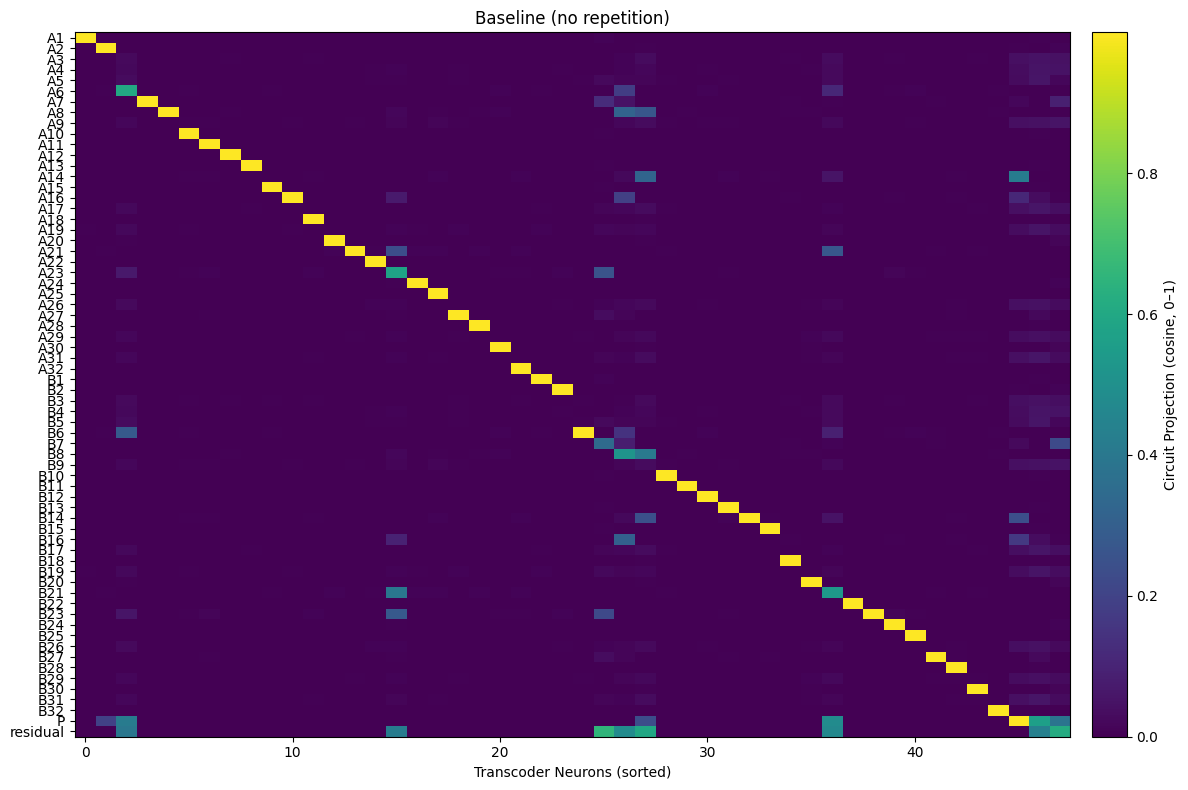

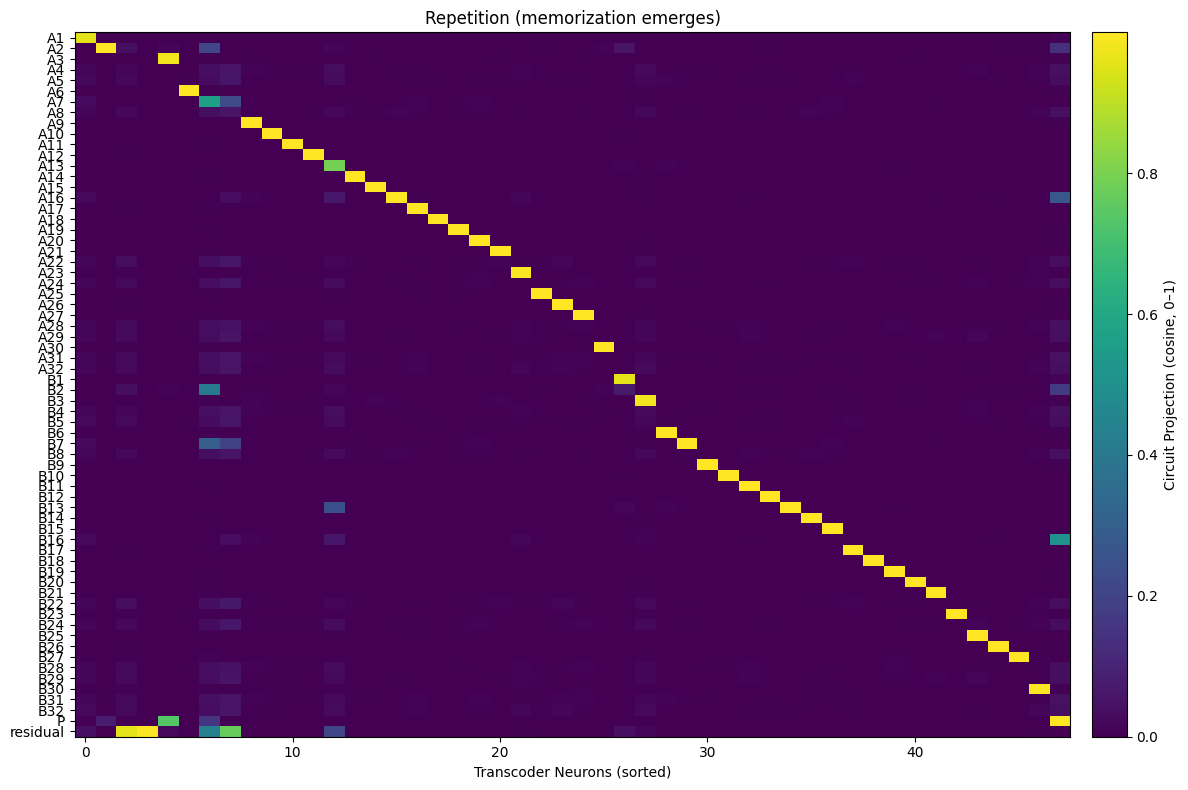

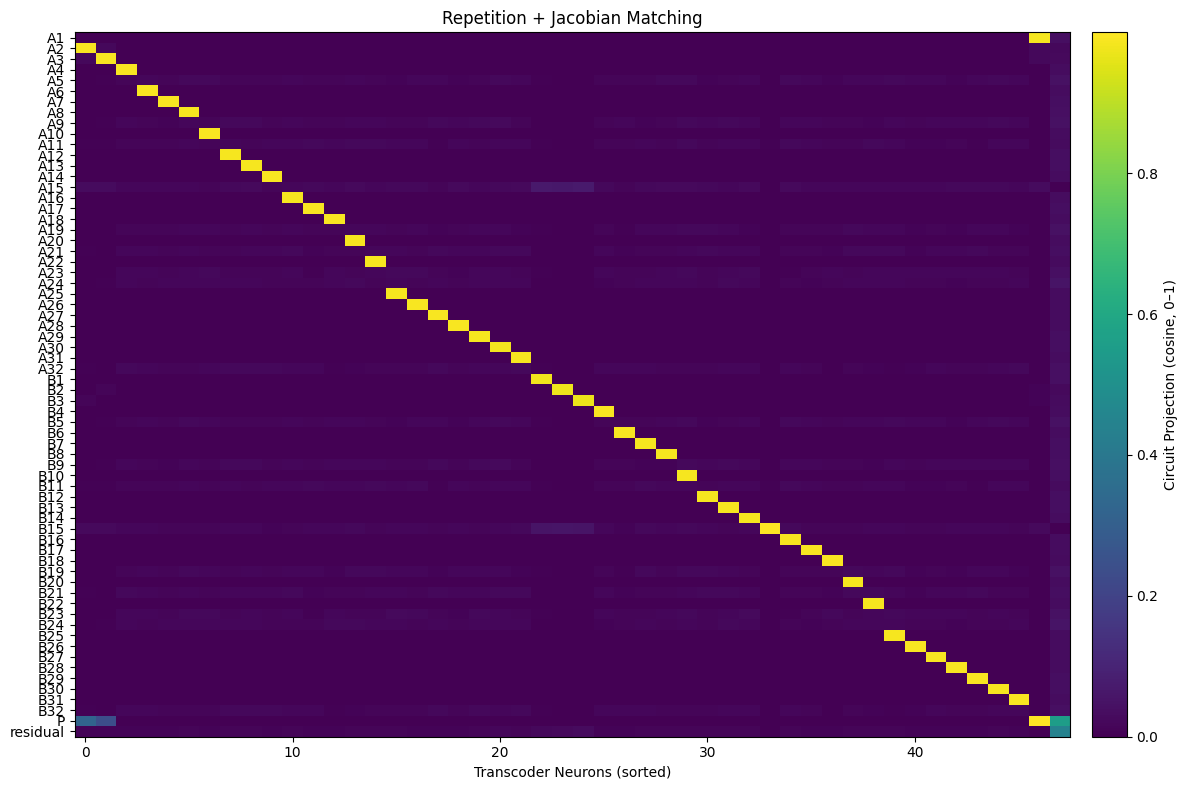

In [18]:
# (If needed) Train models first here.
# model_base = train_transcoder(d=16, hidden=64, repeat_frac=0.0, lam_sparse=1e-3, lam_jac=0.0, steps=2000)
# model_rep  = train_transcoder(d=16, hidden=64, repeat_frac=0.05, lam_sparse=1e-3, lam_jac=0.0, steps=2000)
# model_rep_jac  = train_transcoder(d=16, hidden=64, repeat_frac=0.05, lam_sparse=1e-3, lam_jac=1e-2, steps=2000)

X_eval, _ = sample_data(4000, d=d, repeat_frac=p)  # visualization shows better with distribution including repeated p

names_b, proj_b, best_b = circuit_projection(model_base, X_eval, include_mem_point=True)
plot_circuit_heatmap(names_b, proj_b, best_b, title="Baseline (no repetition)")
plt.savefig("baseline_circuit_heatmap.png")
names_r, proj_r, best_r = circuit_projection(model_rep, X_eval, include_mem_point=True)
plot_circuit_heatmap(names_r, proj_r, best_r, title="Repetition (memorization emerges)")
plt.savefig("repetition_circuit_heatmap.png")

names_j, proj_j, best_j = circuit_projection(model_rep_jac, X_eval, include_mem_point=True)
plot_circuit_heatmap(names_j, proj_j, best_j, title="Repetition + Jacobian Matching")
plt.savefig("repetition_jac_circuit_heatmap.png")
